# Interrupted Time Series (ITS) Counterfactual for a Price Change

This notebook demonstrates a complete, reproducible workflow to estimate the impact of a **price intervention** on **churn** using **Interrupted Time Series (ITS)**.

**Important:** The data used here is **synthetic** (simulated) so the full method can be shared publicly. The workflow is designed to transfer directly to a real churn time series by swapping in your data source and aligning variable definitions.

## What you’ll see
1. Build a time series with trend + seasonality + noise and an intervention point  
2. Fit a segmented ITS regression (level + slope change)  
3. Construct a **counterfactual** (no-intervention) trajectory  
4. Estimate pointwise and cumulative impact  
5. Validate with residual diagnostics (ACF/PACF), placebo tests, and sensitivity checks


In [1]:
# Core stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(7)

def make_weekly_calendar(start="2023-01-07", periods=156, freq="W-SAT"):
    """
    Create a weekly calendar with:
      - week: timestamp
      - t: integer time index (0..N-1)
      - month: categorical month (seasonality)
    """
    idx = pd.date_range(start=start, periods=periods, freq=freq)
    df = pd.DataFrame({"week": idx})
    df["t"] = np.arange(len(df))
    df["month"] = df["week"].dt.month.astype("category")
    return df

def ar1_noise(n, phi=0.6, sigma=0.0025):
    """AR(1) noise to mimic time-series autocorrelation.

    eps_t = phi*eps_{t-1} + eta_t,  eta_t ~ N(0, sigma^2)
    """
    eps = np.zeros(n)
    eta = np.random.normal(0, sigma, size=n)
    for i in range(1, n):
        eps[i] = phi * eps[i-1] + eta[i]
    return eps


## 1) Create a realistic synthetic dataset We simulate weekly churn with:
- baseline level + mild trend - month seasonality (`C(month)`) - a shared marketing/traffic covariate - autocorrelated noise (so HAC - Heteroskedasticity- and Autocorrelation-Consistent (standard errors) - matters) - an intervention (price increase) that causes: - an immediate *level shift* (jump) - a *slope change* (trend change) This mirrors common subscription churn dynamics without using any real data.

In [2]:
df = make_weekly_calendar(periods=156)  # ~3 years weekly

# Synthetic intervention date (price increase)
intervention_week = pd.Timestamp("2025-01-04")  # arbitrary synthetic date

# ITS features
df["post"] = (df["week"] >= intervention_week).astype(int)

# time since intervention (0 pre, 0 at intervention, 1.. post)
t0 = df.loc[df["week"] >= intervention_week, "t"].min()
df["t_post"] = np.where(df["post"].eq(1), df["t"] - t0, 0)

# Exogenous covariate (shared driver): marketing/traffic index
df["mkt_index"] = 100 + 3*np.sin(2*np.pi*df["t"]/26) + 0.6*np.random.normal(size=len(df))

# Month seasonality effects on churn
# (values are synthetic; relative differences create seasonality)
month_effect = {
    1:  0.0020, 2:  0.0015, 3:  0.0005, 4: -0.0005,
    5: -0.0010, 6: -0.0012, 7: -0.0006, 8: -0.0003,
    9:  0.0004, 10: 0.0010, 11: 0.0016, 12: 0.0022,
}

# "True" data generating process parameters (synthetic)
base_level = 0.080
base_trend = 0.00002   # mild upward drift
beta_mkt   = -0.00035  # higher marketing index -> slightly lower churn (retention pressure)

level_jump = 0.006     # immediate churn increase at intervention
slope_change = 0.00004 # trend increases post-intervention

# Treatment series: receives the intervention effect
df["churn_treat"] = (
    base_level
    + base_trend*df["t"]
    + df["month"].astype(int).map(month_effect)
    + beta_mkt*(df["mkt_index"] - df["mkt_index"].mean())
    + level_jump*df["post"]
    + slope_change*df["t_post"]
    + ar1_noise(len(df), phi=0.60, sigma=0.0025)
)

# A "control-like" series: similar dynamics but NO intervention effect
# (This is just to illustrate shared shocks; if everyone is treated, you would drop this.)
df["churn_ctrl"] = (
    (base_level - 0.002)
    + (base_trend*0.9)*df["t"]
    + df["month"].astype(int).map(month_effect) * 0.9
    + beta_mkt*(df["mkt_index"] - df["mkt_index"].mean()) * 0.8
    + ar1_noise(len(df), phi=0.55, sigma=0.0020)
)

# Bounds
df["churn_treat"] = df["churn_treat"].clip(0.0, 1.0)
df["churn_ctrl"]  = df["churn_ctrl"].clip(0.0, 1.0)

# Controlled outcome (difference) to absorb shared shocks
df["y"] = df["churn_treat"] - df["churn_ctrl"]

df.head()


,week,t,month,post,t_post,mkt_index,churn_treat,churn_ctrl,y
0,2023-01-07,0,1,0,0,101.014315,0.081637,0.079510,0.002127
1,2023-01-14,1,1,0,0,100.438385,0.083755,0.080308,0.003447
2,2023-01-21,2,1,0,0,101.413862,0.085691,0.078046,0.007645
3,2023-01-28,3,1,0,0,102.233878,0.086214,0.077230,0.008984
4,2023-02-04,4,2,0,0,101.995598,0.081516,0.083483,-0.001967


### Quick visual sanity check
We plot treatment, control-like, and the differenced outcome used for ITS.

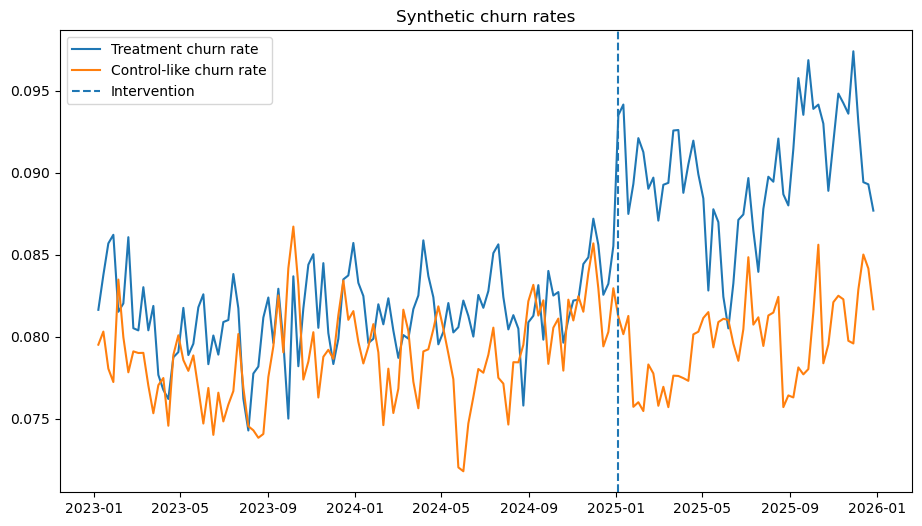

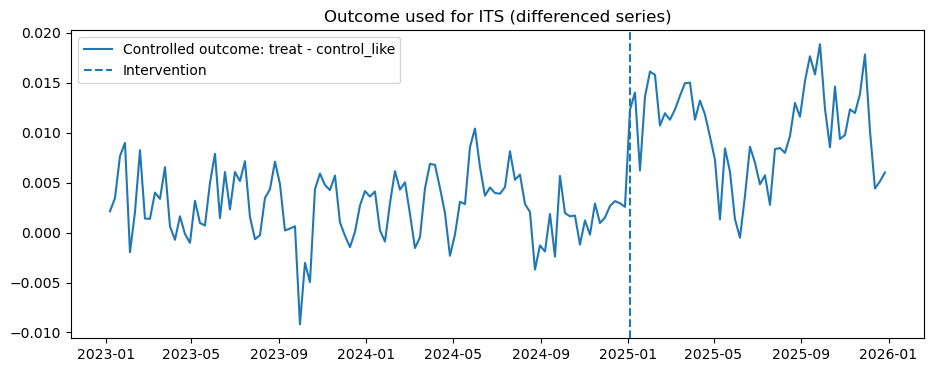

In [4]:
fig = plt.figure(figsize=(11, 6))
plt.plot(df["week"], df["churn_treat"], label="Treatment churn rate")
plt.plot(df["week"], df["churn_ctrl"], label="Control-like churn rate")
plt.axvline(intervention_week, linestyle="--", label="Intervention")
plt.title("Synthetic churn rates")
plt.legend()
plt.show()

fig = plt.figure(figsize=(11, 4))
plt.plot(df["week"], df["y"], label="Controlled outcome: treat - control_like")
plt.axvline(intervention_week, linestyle="--", label="Intervention")
plt.title("Outcome used for ITS (differenced series)")
plt.legend()
plt.show()


### What this chart shows
This plot visualizes the time series around the intervention date (the vertical line).

- **Before the intervention:** the series follows a baseline trend plus seasonality and noise.
- **After the intervention:** the observed series may shift in **level** (an immediate jump) and/or **slope** (a change in trend).
- The goal of Interrupted Time Series (ITS) is to estimate what would have happened **without** the intervention and compare it to what actually happened.


## 2) Fit the Interrupted Time Series model (segmented regression) We model the outcome with:
- `t`: baseline trend - `post`: immediate level change at the intervention - `t_post`: slope change after the intervention - `C(month)`: month seasonality Then we use **HAC/Newey–West** standard errors to protect inference under autocorrelation.

In [5]:
# Fit OLS segmented regression
ols = smf.ols("y ~ t + post + t_post + C(month)", data=df).fit()

# HAC / Newey–West robust standard errors (lag choice shown later)
hac_lags = 6
ols_hac = smf.ols("y ~ t + post + t_post + C(month)", data=df).fit(
    cov_type="HAC",
    cov_kwds={"maxlags": hac_lags}
)

print("OLS (naive) SE for key terms:")
print(ols.bse[["t", "post", "t_post"]])
print("\nHAC (Newey–West) SE for key terms:")
print(ols_hac.bse[["t", "post", "t_post"]])

ols_hac.summary().tables[1]


OLS (naive) SE for key terms:
t         0.000014
post      0.001647
t_post    0.000042
dtype: float64

HAC (Newey–West) SE for key terms:
t         0.000016
post      0.002120
t_post    0.000049
dtype: float64


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.0038,0.001,3.376,0.001,0.002,0.006
C(month)[T.2],0.0006,0.002,0.372,0.710,-0.002,0.004
C(month)[T.3],0.0001,0.001,0.097,0.923,-0.003,0.003
C(month)[T.4],-0.0018,0.001,-1.244,0.213,-0.005,0.001
C(month)[T.5],-0.0031,0.002,-1.688,0.091,-0.007,0.001
C(month)[T.6],-0.0013,0.002,-0.559,0.576,-0.006,0.003
C(month)[T.7],-0.0015,0.002,-0.732,0.464,-0.006,0.003
C(month)[T.8],-0.0017,0.001,-1.165,0.244,-0.005,0.001
C(month)[T.9],-0.0013,0.003,-0.499,0.618,-0.006,0.004
C(month)[T.10],-0.0024,0.002,-1.418,0.156,-0.006,0.001


## 3) Construct the counterfactual Because the intervention is "turned off" in the counterfactual world, we set:
- `post = 0`
- `t_post = 0` Everything else (time, seasonality) continues as observed. Effect is computed as:
\[
\text{effect}_t = \hat y^{obs}_t - \hat y^{cf}_t
\]

In [6]:
df_pred = df.copy()

# Predictions under the observed world (as-is)
df_pred["y_hat_obs"] = ols_hac.predict(df_pred)

# Counterfactual world: no intervention
df_cf = df_pred.copy()
df_cf["post"] = 0
df_cf["t_post"] = 0
df_pred["y_hat_cf"] = ols_hac.predict(df_cf)

# Estimated incremental effect on the modeled outcome
df_pred["effect"] = df_pred["y_hat_obs"] - df_pred["y_hat_cf"]

post_mask = df_pred["week"] >= intervention_week
avg_effect_post = df_pred.loc[post_mask, "effect"].mean()
cum_effect_post = df_pred.loc[post_mask, "effect"].sum()

avg_effect_post, cum_effect_post


(0.007333595581157344, 0.3813469702201819)

### Plot: observed vs counterfactual (modeled outcome) This is the key portfolio figure: it makes the counterfactual concrete and visually checkable.

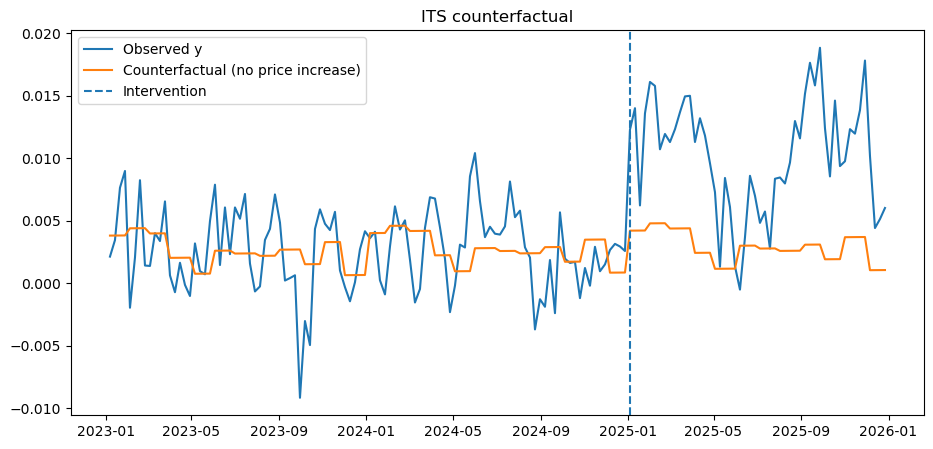

In [7]:
fig = plt.figure(figsize=(11, 5))
plt.plot(df_pred["week"], df_pred["y"], label="Observed y")
plt.plot(df_pred["week"], df_pred["y_hat_cf"], label="Counterfactual (no price increase)")
plt.axvline(intervention_week, linestyle="--", label="Intervention")
plt.title("ITS counterfactual")
plt.legend()
plt.show()


### What this chart shows
These are **ACF/PACF plots of model residuals** (not the raw churn series). They help diagnose whether residuals are autocorrelated.

- **ACF (Autocorrelation Function):** shows how residuals correlate with their own past values across lags.
- **PACF (Partial ACF):** shows the *direct* correlation at each lag after accounting for lower lags.

If residuals are autocorrelated, naive OLS standard errors can be too optimistic. That’s why we use **HAC / Newey–West** standard errors for inference.


### Plot: pointwise and cumulative impact

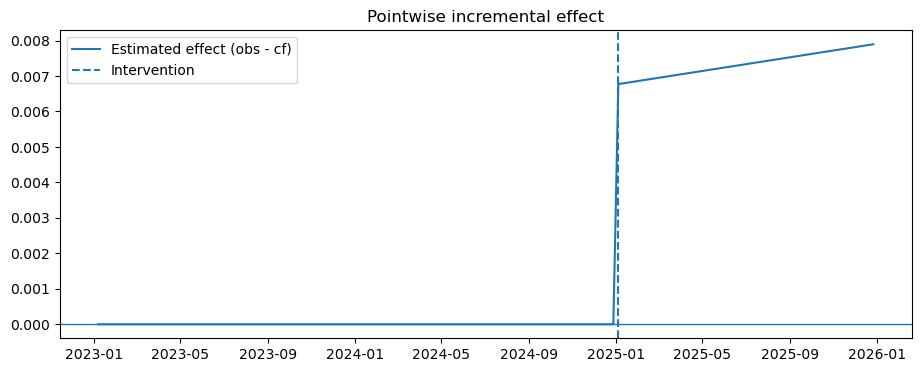

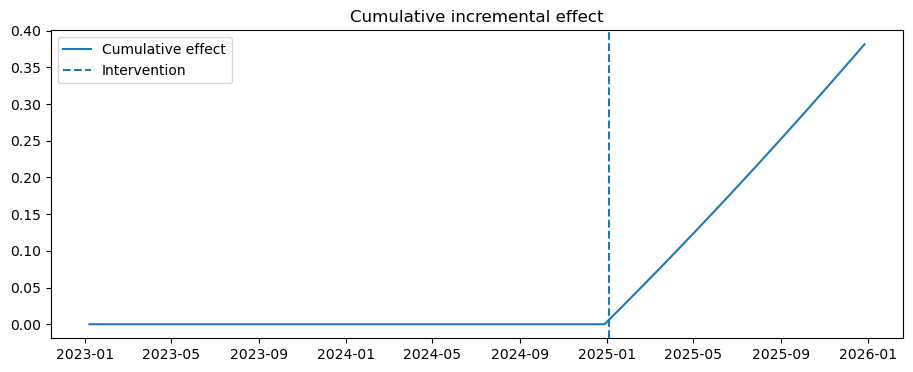

In [8]:
fig = plt.figure(figsize=(11, 4))
plt.plot(df_pred["week"], df_pred["effect"], label="Estimated effect (obs - cf)")
plt.axhline(0, linewidth=1)
plt.axvline(intervention_week, linestyle="--", label="Intervention")
plt.title("Pointwise incremental effect")
plt.legend()
plt.show()

df_pred["cum_effect"] = df_pred["effect"].cumsum()

fig = plt.figure(figsize=(11, 4))
plt.plot(df_pred["week"], df_pred["cum_effect"], label="Cumulative effect")
plt.axvline(intervention_week, linestyle="--", label="Intervention")
plt.title("Cumulative incremental effect")
plt.legend()
plt.show()


### What this chart shows
This chart compares:

- **Observed** outcomes after the intervention (what actually happened), and
- **Counterfactual** outcomes (what the model predicts would have happened if the intervention had not occurred).

The vertical distance between the observed curve and the counterfactual curve in the post period represents the estimated **incremental impact** attributable to the intervention under the ITS assumptions.


## 4) Robustness: placebo intervention dates A key falsification test: if we pretend the intervention happened earlier (pre-period),
estimated effects should be near zero (on average) over a fixed horizon.

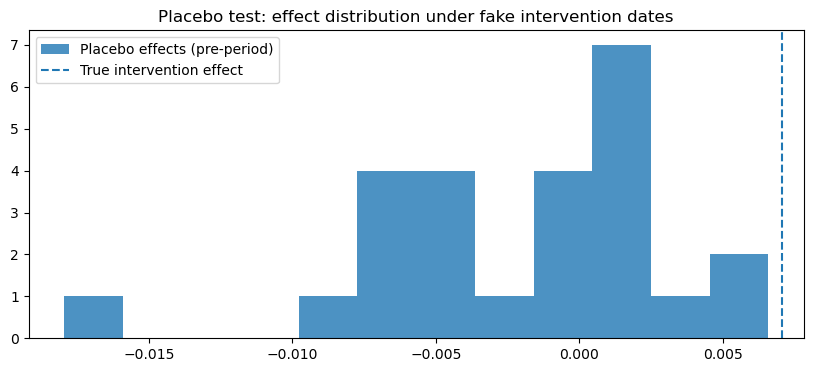

(0.007047363249775525, -0.0019117443593552664, 0.005172996333383847)

In [9]:
def fit_its_and_get_avg_effect(d, intervention_date, horizon_weeks=26, hac_lags=6):
    d = d.copy()
    d["post"] = (d["week"] >= intervention_date).astype(int)
    t0 = d.loc[d["week"] >= intervention_date, "t"].min()
    d["t_post"] = np.where(d["post"].eq(1), d["t"] - t0, 0)

    model = smf.ols("y ~ t + post + t_post + C(month)", data=d).fit()
    model_hac = model.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)

    d_pred = d.copy()
    d_pred["y_hat_obs"] = model_hac.predict(d_pred)
    d_cf = d_pred.copy()
    d_cf["post"] = 0
    d_cf["t_post"] = 0
    d_pred["y_hat_cf"] = model_hac.predict(d_cf)
    d_pred["effect"] = d_pred["y_hat_obs"] - d_pred["y_hat_cf"]

    # fixed horizon window for comparability
    start_t = d_pred.loc[d_pred["week"].ge(intervention_date), "t"].min()
    end_t = start_t + horizon_weeks - 1
    mask = (d_pred["t"] >= start_t) & (d_pred["t"] <= end_t)
    return float(d_pred.loc[mask, "effect"].mean())

horizon_weeks = 26
true_effect = fit_its_and_get_avg_effect(df, intervention_week, horizon_weeks=horizon_weeks, hac_lags=hac_lags)

# Candidate placebos: pre-intervention with enough runway for the horizon window
candidate = df.loc[df["week"] < intervention_week].copy()
candidate = candidate.loc[candidate["t"] <= (df["t"].max() - horizon_weeks)]
placebo_dates = np.random.choice(candidate["week"], size=25, replace=False)

placebo_effects = [fit_its_and_get_avg_effect(df, pd.Timestamp(d), horizon_weeks=horizon_weeks, hac_lags=hac_lags)
                   for d in placebo_dates]

# Plot placebo distribution vs true
fig = plt.figure(figsize=(10, 4))
plt.hist(placebo_effects, bins=12, alpha=0.8, label="Placebo effects (pre-period)")
plt.axvline(true_effect, linestyle="--", label="True intervention effect")
plt.title("Placebo test: effect distribution under fake intervention dates")
plt.legend()
plt.show()

true_effect, float(np.mean(placebo_effects)), float(np.std(placebo_effects))


### What this chart shows
This section visualizes the estimated impact in two complementary ways:

- **Pointwise (per-period) effect:** the estimated incremental change at each time point after the intervention.
- **Cumulative effect:** the running total of incremental change across the post period.

Pointwise effects show *when* the impact is strongest (immediate vs delayed). Cumulative effects show the *total* impact over the evaluation window.


## 5) Sensitivity checks ### A) HAC lag sensitivity
Re-estimate the average effect under different HAC lag choices. ### B) Pre-period window sensitivity
Fit using different pre-period lengths to see if results are stable.

In [10]:
# A) HAC lag sensitivity
lags_to_try = [2, 4, 6, 8, 12]
lag_results = []
for L in lags_to_try:
    eff = fit_its_and_get_avg_effect(df, intervention_week, horizon_weeks=26, hac_lags=L)
    lag_results.append((L, eff))

pd.DataFrame(lag_results, columns=["hac_maxlags", "avg_effect_26w"]).sort_values("hac_maxlags")


,hac_maxlags,avg_effect_26w
0,2,0.007047
1,4,0.007047
2,6,0.007047
3,8,0.007047
4,12,0.007047


In [11]:
# B) Pre-period window sensitivity
# Fit the model using only the last N weeks before the intervention (plus full post),
# to see if pre-trend choice changes the estimated effect.

def prewindow_fit_effect(d, pre_weeks=52, hac_lags=6):
    d = d.copy()
    pre = d.loc[d["week"] < intervention_week].copy()
    post = d.loc[d["week"] >= intervention_week].copy()
    pre = pre.tail(pre_weeks)
    d2 = pd.concat([pre, post], ignore_index=True)

    model = smf.ols("y ~ t + post + t_post + C(month)", data=d2).fit()
    model_hac = model.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)

    d_pred = d2.copy()
    d_pred["y_hat_obs"] = model_hac.predict(d_pred)
    d_cf = d_pred.copy()
    d_cf["post"] = 0
    d_cf["t_post"] = 0
    d_pred["y_hat_cf"] = model_hac.predict(d_cf)
    d_pred["effect"] = d_pred["y_hat_obs"] - d_pred["y_hat_cf"]
    return float(d_pred.loc[d_pred["week"] >= intervention_week, "effect"].mean())

pre_windows = [26, 52, 78, 104]  # ~6mo, 1y, 1.5y, 2y
pw = [(w, prewindow_fit_effect(df, w, hac_lags=hac_lags)) for w in pre_windows]
pd.DataFrame(pw, columns=["pre_weeks_used", "avg_post_effect"])


,pre_weeks_used,avg_post_effect
0,26,0.002735
1,52,0.008628
2,78,0.007045
3,104,0.007334


## Takeaways / How to adapt this to your real work - If everyone is treated (global price increase), run **single-series ITS** on your churn rate directly.
- The counterfactual is the model-based projection of pre-period dynamics into the post period with `post=0` and `t_post=0`.
- Use ACF/PACF on residuals to justify autocorrelation handling; report HAC robust SEs (or AR errors) for valid inference.
- Include **placebo dates** + **sensitivity** checks to strengthen credibility. *All data and figures here are synthetic and intended for demonstration only.*